Initial preparation by Valery Ilin

Modified by: Elvira Zainulina

In [232]:
! pip install math3d

  Created wheel for math3d: filename=math3d-3.3.5-cp37-none-any.whl size=69836 sha256=c1c2906a040c2bb9c0141ccac5bb4f4adb16f26f2996c281fee3ebc1dccd8ffc
  Stored in directory: C:\Users\E89F~1\AppData\Local\pip\Cache\wheels\5b\f5\43\086ff5b26170976482cfbb96563c731444cb4adb5d2f30aa71
Successfully built math3d


In [233]:
import pyrealsense2 as rs
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
import math3d as m3d

# Collecting frames for next dev

In [2]:
count_of_frames = 15
frames_between_frames_D435 = 20

# Iitial configs

In [8]:
# data filenames
d435_filename = '../data/D435.bag'
t265_filename = '../data/T265.bag'

In [9]:
# config fo D435
cfg_d435 = rs.config()
cfg_d435.enable_device_from_file(d435_filename)
cfg_d435.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 30)
pipe_d435 = rs.pipeline()
pipe_d435.start(cfg_d435)


In [10]:
# config fo T265
cfg_t265 = rs.config()
cfg_t265.enable_device_from_file(t265_filename)
cfg_t265.enable_stream(rs.stream.pose)
pipe_t265 = rs.pipeline()
pipe_t265.start(cfg_t265)

## Collecting frames

In [262]:
# rewind
for i in range(frames_between_frames_D435*count_of_frames*2):
    pipe_d435.wait_for_frames()

In [11]:
d435_frames = []
while len(d435_frames) != count_of_frames:
    for i in range(frames_between_frames_D435):
        depth_frame = pipe_d435.wait_for_frames().get_depth_frame()
    d435_frames.append(depth_frame)

In [12]:
pose_frame = None
pose_frame_time = -1
thresh = 7
t265_frames = []
t265_frames_temp = []
n = 0

for i, depth_frame in enumerate(d435_frames):
    depth_frame_time = depth_frame.get_timestamp()
    while abs(depth_frame_time-pose_frame_time) > thresh:
        pose_frame = pipe_t265.wait_for_frames().get_pose_frame()
        pose_frame_time = pose_frame.get_timestamp()
    while abs(depth_frame_time-pose_frame_time) <= thresh:
        pose_frame = pipe_t265.wait_for_frames().get_pose_frame()
        t265_frames_temp.append(pose_frame)
        pose_frame_time = pose_frame.get_timestamp()

    min_int_index = 0
    min_interval = thresh * 2
    for ind_pose, temp_pose in enumerate(t265_frames_temp):
        if abs(depth_frame_time-temp_pose.get_timestamp())<min_interval:
            min_interval = abs(depth_frame_time-temp_pose.get_timestamp())
            min_int_index = ind_pose
    t265_frames.append(t265_frames_temp[min_int_index])
    

## Test for frames

In [13]:
def count_diff_frames(frames):
    prev_frame = None
    for i, frame in enumerate(frames):
        if prev_frame is not None:
            print("Difference bw {0} and {1} frames is {2:.4f} ms".format(i, i-1, frame.get_timestamp()-prev_frame.get_timestamp()))
        prev_frame = frame

In [14]:
def get_diff_sensors(frames1, frames2):
    if len(frames1) != len(frames2):
        return
    else:
        for i in range(len(frames1)):
            print("Difference bw frames1[{0}] and frames2[{0}] frames is {1:.4f} ms".format(i, frames1[i].get_timestamp()-frames2[i].get_timestamp()))
        

In [15]:
count_diff_frames(d435_frames)
count_diff_frames(t265_frames)

Difference bw 1 and 0 frames is 667.0691 ms
Difference bw 2 and 1 frames is 667.0452 ms
Difference bw 3 and 2 frames is 667.5667 ms
Difference bw 4 and 3 frames is 666.6289 ms
Difference bw 5 and 4 frames is 667.0698 ms
Difference bw 6 and 5 frames is 667.1248 ms
Difference bw 7 and 6 frames is 666.9629 ms
Difference bw 8 and 7 frames is 667.1738 ms
Difference bw 9 and 8 frames is 667.0598 ms
Difference bw 10 and 9 frames is 667.2993 ms
Difference bw 11 and 10 frames is 666.9736 ms
Difference bw 12 and 11 frames is 666.9241 ms
Difference bw 13 and 12 frames is 667.0981 ms
Difference bw 14 and 13 frames is 667.0381 ms
Difference bw 1 and 0 frames is 665.1045 ms
Difference bw 2 and 1 frames is 664.7583 ms
Difference bw 3 and 2 frames is 669.8647 ms
Difference bw 4 and 3 frames is 664.9285 ms
Difference bw 5 and 4 frames is 669.9065 ms
Difference bw 6 and 5 frames is 664.8928 ms
Difference bw 7 and 6 frames is 669.9478 ms
Difference bw 8 and 7 frames is 664.8962 ms
Difference bw 9 and 8 f

In [16]:
get_diff_sensors(d435_frames, t265_frames)

Difference bw frames1[0] and frames2[0] frames is -2.7410 ms
Difference bw frames1[1] and frames2[1] frames is -0.7764 ms
Difference bw frames1[2] and frames2[2] frames is 1.5105 ms
Difference bw frames1[3] and frames2[3] frames is -0.7876 ms
Difference bw frames1[4] and frames2[4] frames is 0.9128 ms
Difference bw frames1[5] and frames2[5] frames is -1.9238 ms
Difference bw frames1[6] and frames2[6] frames is 0.3081 ms
Difference bw frames1[7] and frames2[7] frames is -2.6768 ms
Difference bw frames1[8] and frames2[8] frames is -0.3992 ms
Difference bw frames1[9] and frames2[9] frames is 1.8359 ms
Difference bw frames1[10] and frames2[10] frames is -0.7944 ms
Difference bw frames1[11] and frames2[11] frames is 1.2351 ms
Difference bw frames1[12] and frames2[12] frames is -1.7473 ms
Difference bw frames1[13] and frames2[13] frames is 0.4675 ms
Difference bw frames1[14] and frames2[14] frames is -2.3796 ms


# Analysis

## Helpers

In [17]:
import time
from functools import wraps

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        time_start = time.time()
        result = f(*args, **kw)
        time_end = time.time()
        print('----------func:%r took: %2.4f sec' % (f.__name__, time_end-time_start))
        return result
    return wrap

In [18]:
tm_T265toD435 = np.array([[0.999968402, -0.006753626, -0.004188075, -0.015890727],
                          [-0.006685408, -0.999848172, 0.016093893, 0.028273059],
                          [-0.004296131, -0.016065384, -0.999861654, -0.009375589],
                          [0, 0, 0, 1]])

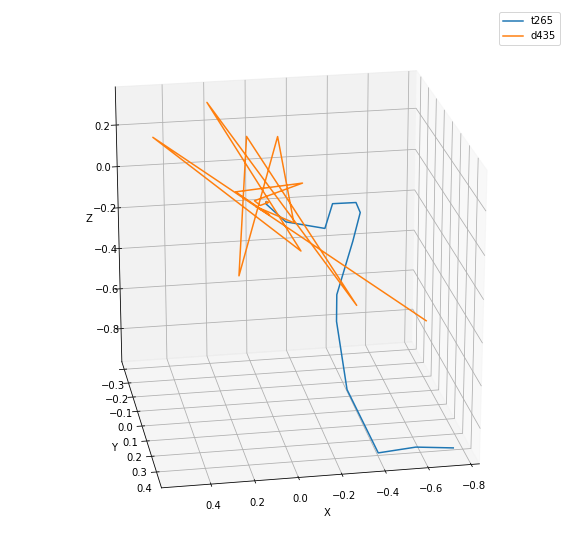

In [19]:
# Graph plot
t265 = np.load('../logs/points_trajectory_T265.npy') #np array coords
d435 = np.load('../logs/points_trajectory_D435.npy')/1 # np array coords
# before = 10
before = d435.shape[0]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(t265[:before, 0], t265[:before, 1], t265[:before, 2], label='t265')
ax.plot(d435[:before, 0], d435[:before, 1], d435[:before, 2], label='d435')
ax.view_init(elev=22, azim=80)
plt.legend()

## Functions

In [108]:
def get_transformation265(pose):
    data = pose.get_pose_data()
    data_rot = [float(i.strip('xyzw: ')) for i in str(data.rotation).split(', ')]
    r = R.from_quat(data_rot)
    rotation = np.array(r.as_dcm())
    translation = np.array([float(i.strip('xyzw: ')) for i in str(data.translation).split(', ')])[np.newaxis].T
    T = np.hstack((rotation, translation))
    T = np.vstack((T, np.array([0, 0, 0, 1])))
    return T

In [109]:
get_transformation265(t265_frames[0])

array([[ 0.8453492 ,  0.21375752, -0.48958397, -0.200942  ],
       [-0.01937762,  0.92812282,  0.37176948,  0.29152   ],
       [ 0.53386257, -0.30478806,  0.78872999,  0.0805094 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [242]:
def apply_transformation(transformation, points):
    """

    :param transformation: 4x4 np.array
    :param points: Nx3 np.array
    :return: transformed Nx3 np.array
    """
    if transformation is None or points is None:
        return None
    else:
        coordinates = np.hstack((points, np.ones((points.shape[0], 1))))
        return (transformation @ coordinates.T).T[:, :-1]

In [882]:
def get_coordinates(depth_frame, make_sampling=True, koef = 2**2):
    """
     TODO
    :param make_sampling:
    :return:
    """
    pc = rs.pointcloud()
    if make_sampling:
        decimate = rs.decimation_filter()
        decimate.set_option(rs.option.filter_magnitude, koef)
        depth_frame = decimate.process(depth_frame)

        points = pc.calculate(depth_frame).as_points()
    else:
        points = pc.calculate(depth_frame).as_points()

    coordinates = np.ndarray(buffer=points.get_vertices(), dtype=np.float32, shape=(points.size(), 3))
    coordinates[coordinates[:, 2] > 1.5] = 0
    coordinates[coordinates[:, 2] < 0.5] = 0
    
    coordinates = coordinates[coordinates[:, 2] != 0]
#     coordinates[:, 1] *= -1 
#     coordinates[:, 2] *= -1

    coordinates = apply_transformation(tm_T265toD435, coordinates)
    return coordinates


In [883]:
def convert_to_pcl(points):
    """
        TODO
    :param points: Nx3
    :return:
    """
    if points is None:
        return None
    else:
        return o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points))

In [884]:
# TODO this 100%

def get_transformation435(self, max_point_pair_dist=0.2, init_guess=np.eye(4)):
    old_point_cloud = self.apply_transformation(self.prev_tm, self.point_cloud)
    old_pcl = self.convert_to_pcl(old_point_cloud) # n-1
    self.point_cloud = self.apply_transformation(self.prev_tm, self.get_coordinates())
    if old_pcl is None:
        self.prev_tm = init_guess
        print("\n\n\n{}\n\n\n".format(init_guess))
        return None

    new_pcl = self.convert_to_pcl(self.point_cloud) # n

    tr_mx = o3d.registration.registration_icp(old_pcl, new_pcl, max_point_pair_dist,
                                              self.prev_tm, o3d.registration.TransformationEstimationPointToPoint())\
        .transformation
    self.prev_tm = tr_mx
    return tr_mx

In [885]:
def plot_PC(Y, TX, ax=None, plot_lines=True):
    ax_is_None = False
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax_is_None = True
    ax.plot(Y[:,0], Y[:,1], Y[:,2], 'o', label='source points')
    ax.plot(TX[:,0], TX[:,1], TX[:,2], 'o', label='dest points')
    if plot_lines:
        for i in range(Y.shape[0]):
            ax.plot([Y[i,0], TX[i,0]], [Y[i,1], TX[i,1]], [Y[i,2], TX[i,2]], 
                    'g--')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend()
    
    if ax_is_None:
        plt.tight_layout()
        plt.show()

In [886]:
d435_frames

In [887]:
t265_frames

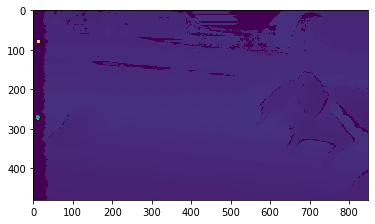

In [888]:
from IPython.display import clear_output

for i in range(len(d435_frames)):
    clear_output(wait=True)
    plt.imshow(d435_frames[i].get_data())
    plt.show()

In [889]:
points = [get_coordinates(depth) for depth in d435_frames]
pcl = [convert_to_pcl(point) for point in points]

In [890]:
points[0].shape

(19494, 3)

In [891]:
regs = []
tr_mxs = []
rmses = 0
for i in range(1, len(points)):
    tr_cur = get_transformation265(t265_frames[i])
    tr_prev = get_transformation265(t265_frames[i-1])
    reg = o3d.registration.registration_icp(pcl[i], pcl[i-1], 1)
    print(i, reg.fitness, reg.inlier_rmse)
    tr_mx = reg.transformation
    regs.append(reg)
    tr_mxs.append(tr_mx)
    rmses += reg.inlier_rmse

1 1.0 0.07481420602312135
2 1.0 0.02860596591617126
3 1.0 0.06256219421924412
4 1.0 0.03377898483415419
5 1.0 0.03186714887714499
6 1.0 0.027944152084172592
7 1.0 0.01743597385056698
8 1.0 0.020194107835948657
9 1.0 0.016697259031554012
10 1.0 0.022596470706703717
11 1.0 0.040194894495463276
12 1.0 0.0468389062780366
13 1.0 0.05677968617783057
14 1.0 0.07111980639275753


In [892]:
rmses / 14

0.03938783976591927

In [893]:
regs = []
tr_mxs = []
rmses = 0
for i in range(1, len(points)):
    tr_cur = get_transformation265(t265_frames[i])
    tr_prev = get_transformation265(t265_frames[i-1])
    reg = o3d.registration.registration_icp(pcl[i], pcl[i-1], 1, tr_cur @ np.linalg.inv(tr_prev))
    print(i, reg.fitness, reg.inlier_rmse)
    tr_mx = reg.transformation
    regs.append(reg)
    tr_mxs.append(tr_mx)
    rmses += reg.inlier_rmse

1 1.0 0.07506953391144207
2 1.0 0.028714577322632554
3 1.0 0.061977962947794896
4 1.0 0.029570848895844177
5 1.0 0.03125148850674012
6 1.0 0.027931193537867865
7 1.0 0.017440878449267554
8 1.0 0.02009813656431598
9 1.0 0.01669357463014344
10 1.0 0.022595168371571966
11 1.0 0.04019533446399842
12 1.0 0.046789625616853854
13 1.0 0.056667475068490215
14 1.0 0.07048859600082831


In [894]:
rmses / 14

0.03896317102055653

In [899]:
def visualise_transf(points0, points1, reg, size=30):
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    cor = np.asarray(reg.correspondence_set)
    set0 = points0[cor[:, 1]]
    set1 = points1[cor[:, 0]]
    inds = np.random.choice(len(cor), size=size, replace=False)
    set0 = set0[inds]
    set1 = set1[inds]
    plot_PC(set0, set1, ax1)
    Tset0 = (reg.transformation @ (np.vstack((set1.T, np.ones(set1.shape[0]))))).T
    plot_PC(Tset0, set1, ax2)
    plt.tight_layout()
    plt.show()
    return set0, set1, Tset0


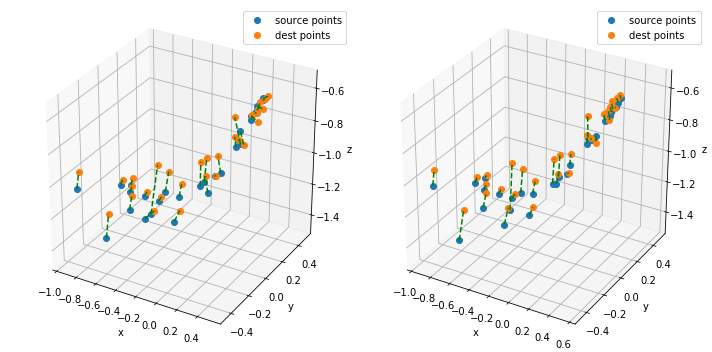

In [900]:
set0, set1, Tset0 = visualise_transf(points[0], points[1], regs[0])

In [901]:
points_trajectory_T265 = []
T265_tr_mcs = []
for pose in t265_frames:
    tr_mx = get_transformation265(pose)
    T265_tr_mcs.append(tr_mx)
    points_trajectory_T265.append(tr_mx[:3, -1])
points_trajectory_T265 = np.array(points_trajectory_T265)
T265_tr_mcs = np.array(T265_tr_mcs)

In [902]:
T = T265_tr_mcs[0]
t = T[:3, -1]
R_ = T[:3, :3]
trajectory = [t]
poses = [R_]

In [903]:
for i in range(len(tr_mxs)):
    T = T @ tr_mxs[i]
    
    trajectory.append(T[:3, -1]) #-t moves point cloud into (0,0) of the initial state 
    poses.append(T[:3, :3]) #R_^-1 translates point cloud into the state of initial frame

In [904]:
rot_mx = np.array([
    [1, 0, 0],
    [0, 0, 1],
    [0, -1, 0]
])

In [905]:
trajectory = np.array(trajectory)

tr1 = (rot_mx @ trajectory.T).T

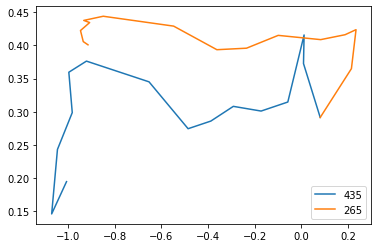

In [906]:
plt.plot(trajectory[:, 2], trajectory[:, 1], label='435')
# plt.plot(tr1[:, 2], tr1[:, 1], label='435')
plt.plot(points_trajectory_T265[:, 2], points_trajectory_T265[:, 1], label='265')
plt.legend()

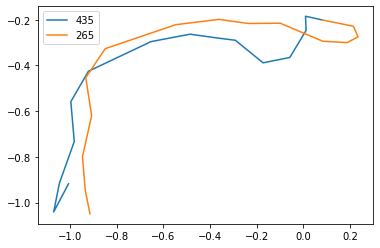

In [907]:
plt.plot(trajectory[:, 2], trajectory[:, 0], label='435')
# plt.plot(tr1[:, 2], tr1[:, 0], label='435')
plt.plot(points_trajectory_T265[:, 2], points_trajectory_T265[:, 0], label='265')
plt.legend()

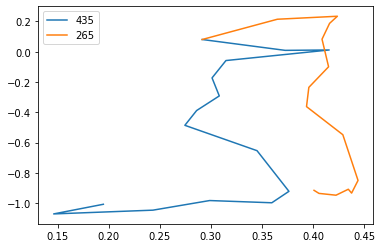

In [908]:
plt.plot(trajectory[:, 1], trajectory[:, 2], label='435')
plt.plot(points_trajectory_T265[:, 1], points_trajectory_T265[:, 2], label='265')
plt.legend()

In [909]:
def plot_pose(c, pose, ax):
    for i, color in enumerate(['r', 'g', 'b']):
        ax.plot([c[0], pose[0, i]+c[0]], 
                [c[1], pose[1, i]+c[1]],
                [c[2], pose[2, i]+c[2]], color)
    
def plot_poses(trajectory, poses):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(trajectory[:,1], trajectory[:, 0], trajectory[:,2], 'k', label='435')
#     ax.plot(tr1[:,1], tr1[:, 0], tr1[:,2], 'r')
#     for i, pose in enumerate(poses):
#         plot_pose(trajectory[i], pose, ax)
    ax.plot(points_trajectory_T265[:,1], points_trajectory_T265[:, 0], points_trajectory_T265[:, 2], label='265')
    plt.tight_layout()
    plt.show()

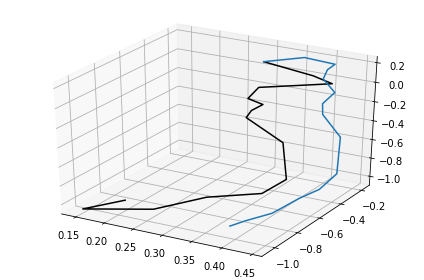

In [910]:
plot_poses(np.array(trajectory), np.array(poses))

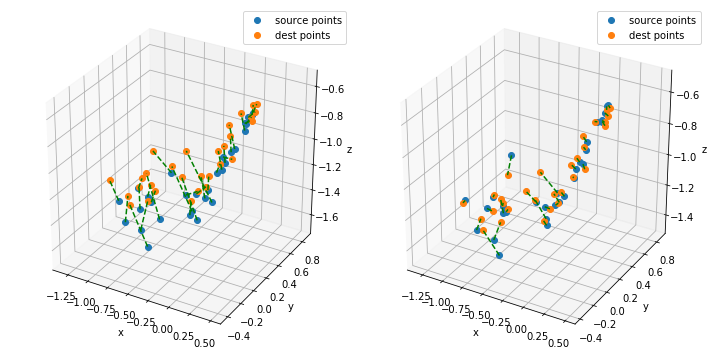

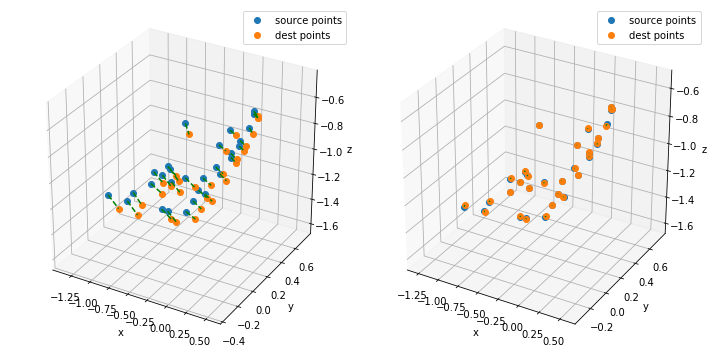

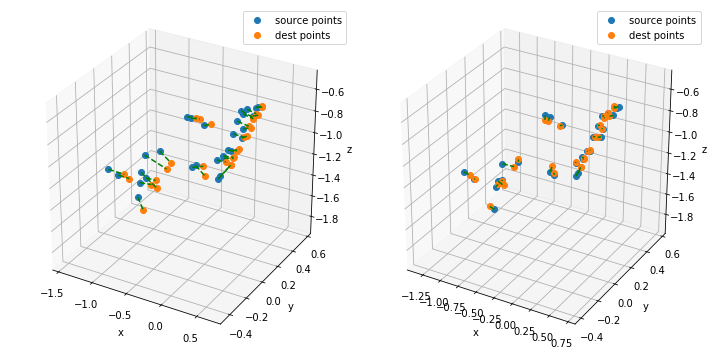

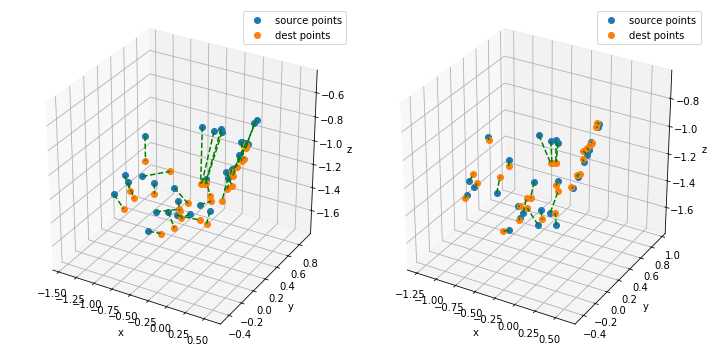

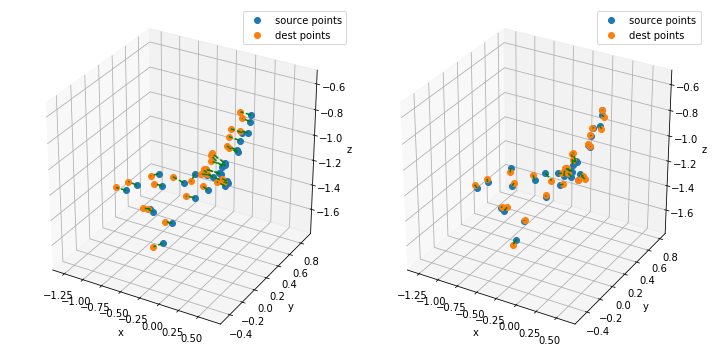

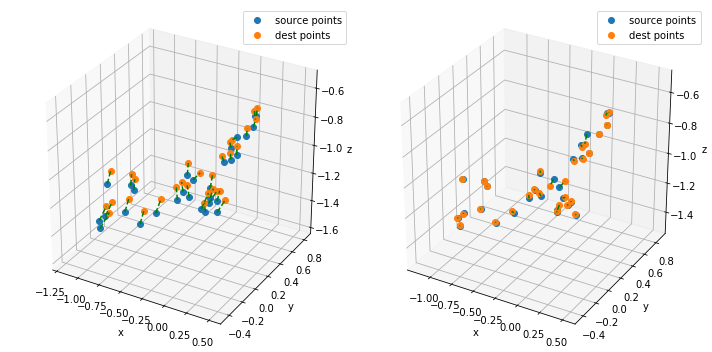

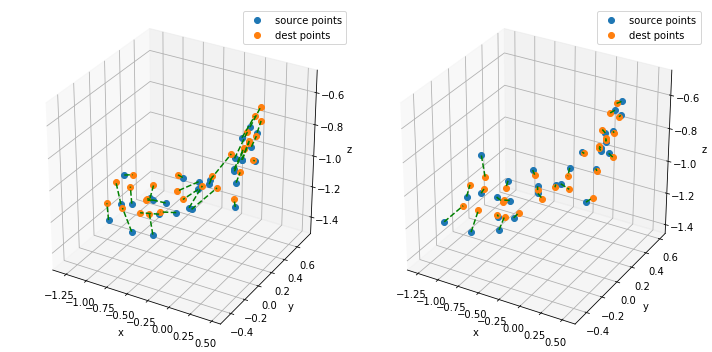

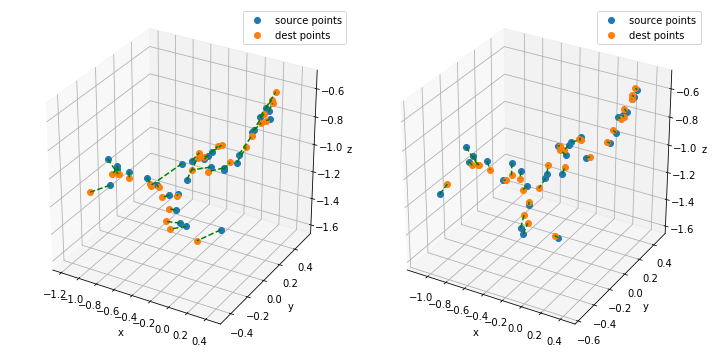

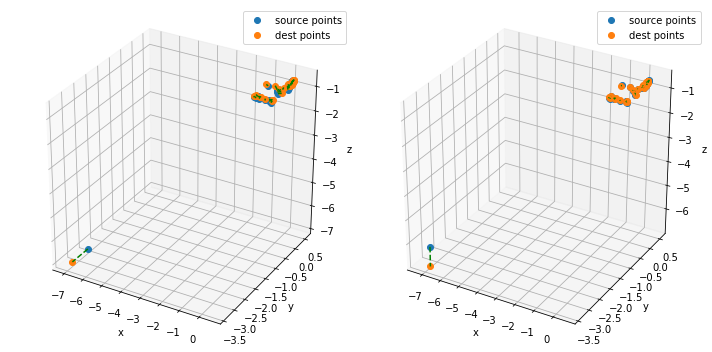

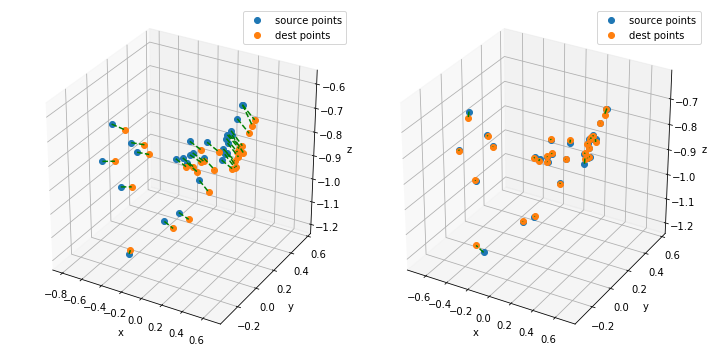

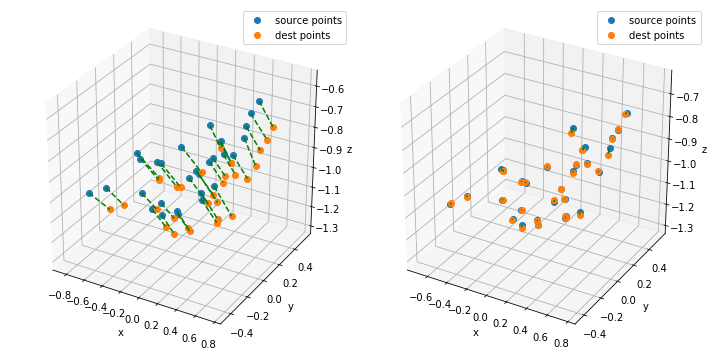

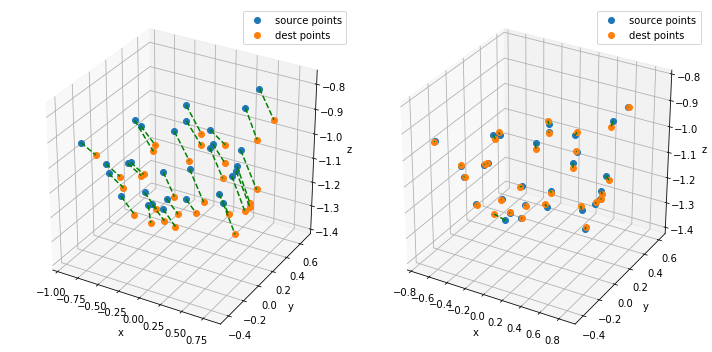

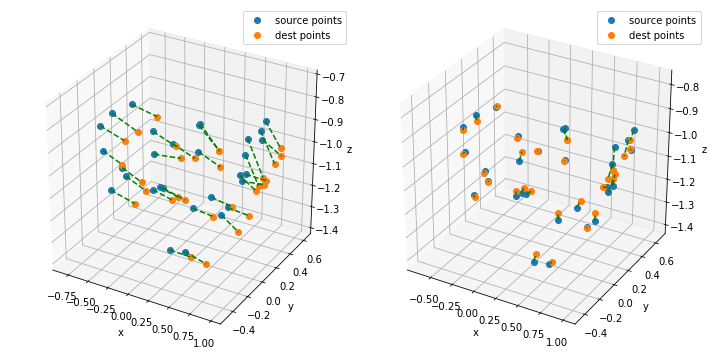

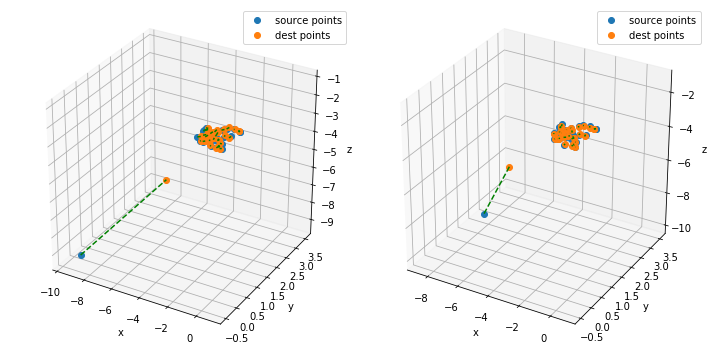

In [132]:
for i in range(len(tr_mxs)):
    _ = visualise_transf(points[i], points[i+1], regs[i])

In [133]:
np.mean(points[0], axis=0)

array([-0.18350832,  0.05978795, -1.03517737])

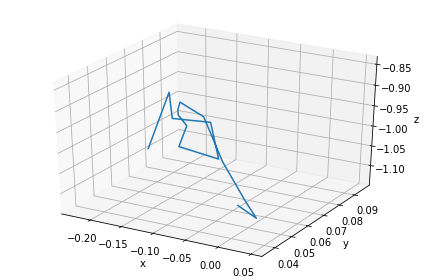

In [134]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
tr = []
for i in range(len(points)):
#     ax.plot(points[i][:50,0], points[i][:50,1], points[i][:50,2], 'o', label=str(i))
    tr.append(np.mean(points[i], axis=0))
tr = np.array(tr)
ax.plot(tr[:,0], tr[:, 1], tr[:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.legend()

plt.tight_layout()
plt.show()

In [135]:
points_trajectory_T265 = []
for pose in t265_frames:
    tr_mx = get_transformation265(pose)
    points_trajectory_T265.append(tr_mx[:3, -1])
points_trajectory_T265 = np.array(points_trajectory_T265)

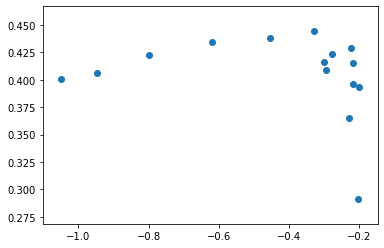

In [136]:
plt.scatter(points_trajectory_T265[:, 0], points_trajectory_T265[:, 1])

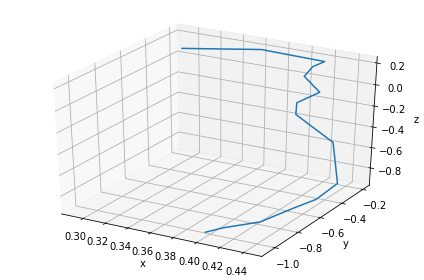

In [137]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot(tr[:,0], tr[:, 1], tr[:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.legend()
ax.plot(points_trajectory_T265[:,1], points_trajectory_T265[:,0], points_trajectory_T265[:,2])
plt.tight_layout()
plt.show()

In [138]:
corr01 = np.asarray(regs[0].correspondence_set)
corr12 = np.asarray(regs[1].correspondence_set)

set0 = points[0][corr01[:, 0]]
set10 = points[1][corr01[:, 1]]
set12 = points[1][corr12[:, 0]]
set2 = points[2][corr12[:, 1]]

In [139]:
def set2str(s):
    s = s.astype(str)
    s = list(map(lambda x: x[0]+'|'+x[1]+'|'+x[2], s))
    return np.array(s)

In [140]:
set10_ = set2str(set10)
set12_ = set2str(set12)

In [141]:
inds10 = []
inds12 = []
for i in tqdm(range(len(set10_))):
    if set10_[i] in set12_:
        inds10.append(i)
        inds12.append(np.argwhere(set12_==set10_[i])[0])

In [142]:
inds10 = np.array(inds10)

In [143]:
len(inds10), inds10[-1]

(24613, 24612)

In [144]:
inds12 = np.array(inds12).squeeze(1)

In [145]:
inds12, len(inds12)

(array([10968, 10968, 10968, ..., 10968, 10968, 10968], dtype=int64), 24613)

In [146]:
set0 = set0[inds10]
set2 = set2[inds12]
set1 = set10[inds10]

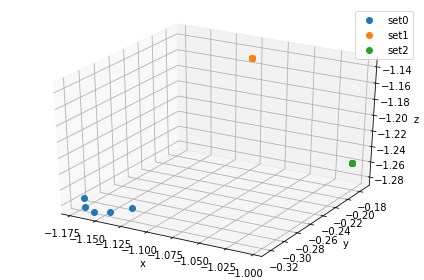

In [162]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(set0[:5,0], set0[:5,1], set0[:5,2], 'o', label='set0')
ax.plot(set1[:5,0], set1[:5,1], set1[:5,2], 'o', label='set1')
ax.plot(set2[:5,0], set2[:5,1], set2[:5,2], 'o', label='set2')
# ax.plot([set0[i,0],set1[i,0]], [set0[i,1], set1[i,1]], [set0[i,2], set1[i,2]], 'g--')
# ax.plot([set1[i,0],set2[i,0]], [set1[i,1], set2[i,1]], [set1[i,2], set2[i,2]], 'r--')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
t

In [190]:
num_of_points = 25
s1 = set0[:num_of_points]
s2 = set1[:num_of_points]
s3 = set2[:num_of_points]

pcl_s1 = convert_to_pcl(s1)
pcl_s2 = convert_to_pcl(s2)
pcl_s3 = convert_to_pcl(s3)

In [191]:
regs_sub = []
tr_mxs_sub = []
rmses = 0

reg = o3d.registration.registration_icp(pcl_s1, pcl_s2, 5)
regs_sub.append(reg)
rmses += reg.inlier_rmse
tr_mxs_sub.append(reg.transformation)

reg = o3d.registration.registration_icp(pcl_s2, pcl_s3, 5)
regs_sub.append(reg)
rmses += reg.inlier_rmse
tr_mxs_sub.append(reg.transformation)

In [212]:
T = T265_tr_mcs[0].copy()
t = T[:3, -1]
R_ = T[:3, :3]
trajectory = [t]
poses = [R_]

for i in range(len(tr_mxs_sub)):
    t_est = tr_mxs_sub[i][:3, -1]
    R_est = tr_mxs_sub[i][:3, :3]

    R_ = R_est @ R_
    t = t + (np.linalg.inv(R_) @ t_est).ravel()
    
    trajectory.append(t) #-t moves point cloud into (0,0) of the initial state 
    poses.append(R_) 
    
trajectory = np.array(trajectory)

In [229]:
T = t265_tr_mcs[0].copy()
tr1 = [T[:3, -1]]
for tr in tr_mxs_sub:
    T = T @ tr
    tr1.append(T[:3, -1])
    
tr1 = np.array(tr1)

In [220]:
T = t265_tr_mcs[0].copy()
tr1 = [T[:3, -1]]
for tr in tr_mxs_sub:
    T = tr @ T
    tr1.append(T[:3, -1])
    
tr1 = np.array(tr1)

In [221]:
len(trajectory)

3

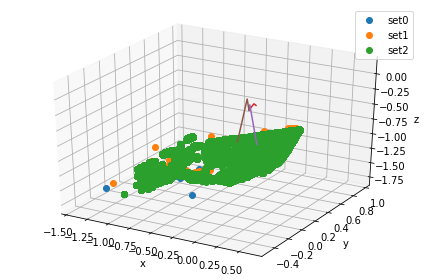

In [230]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(set0[:,0], set0[:,1], set0[:,2], 'o', label='set0')
ax.plot(set1[:,0], set1[:,1], set1[:,2], 'o', label='set1')
ax.plot(set2[:,0], set2[:,1], set2[:,2], 'o', label='set2')
ax.plot(points_trajectory_T265[:3,1], points_trajectory_T265[:3,0], points_trajectory_T265[:3,2])
ax.plot(trajectory[:,1], trajectory[:,0], trajectory[:,2])
ax.plot(tr1[:,1], tr1[:,0], tr1[:,2])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.tight_layout()
plt.show()

In [148]:
set10_tr = (regs[0].transformation @ np.hstack((set0, np.ones((set0.shape[0], 1)))).T).T
set20_tr = (regs[1].transformation @ set10_tr.T).T
set21_tr = (regs[1].transformation @ np.hstack((set1, np.ones((set1.shape[0], 1)))).T).T

In [149]:
set10_tr = set10_tr[:, :-1]
set20_tr = set20_tr[:, :-1]
set21_tr = set21_tr[:, :-1]

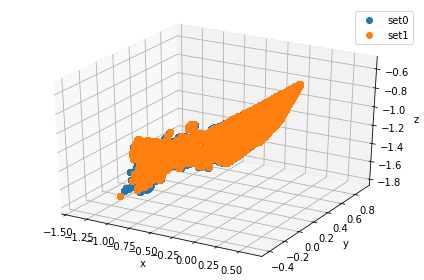

In [150]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot(set10_tr[:,0], set10_tr[:,1], set10_tr[:,2], 'o', label='set0')
# ax.plot(set1[:,0], set1[:,1], set1[:,2], 'o', label='set1')

# ax.plot(set20_tr[:,0], set20_tr[:,1], set20_tr[:,2], 'o', label='set0')
ax.plot(set21_tr[:,0], set21_tr[:,1], set21_tr[:,2], 'o', label='set0')
ax.plot(set2[:,0], set2[:,1], set2[:,2], 'o', label='set1')
# ax.plot(set2[:20,0], set2[:20,1], set2[:20,2], 'o', label='set2')
# ax.plot([set0[i,0],set1[i,0]], [set0[i,1], set1[i,1]], [set0[i,2], set1[i,2]], 'g--')
# ax.plot([set1[i,0],set2[i,0]], [set1[i,1], set2[i,1]], [set1[i,2], set2[i,2]], 'r--')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.tight_layout()
plt.show()

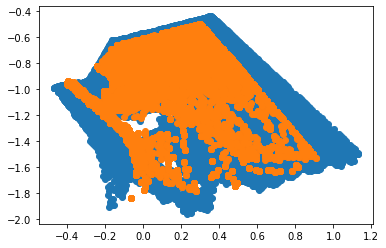

In [153]:
plt.plot(set20_tr[:,1], set20_tr[:,2], 'o', label='set0')
plt.plot(set2[:,1], set2[:,2], 'o', label='set1')

In [154]:
set12_tr = (np.linalg.inv(regs[1].transformation) @ np.hstack((set2, np.ones((set2.shape[0], 1)))).T).T
set01_tr = (np.linalg.inv(regs[0].transformation) @ np.hstack((set1, np.ones((set1.shape[0], 1)))).T).T
set02_tr = (np.linalg.inv(regs[0].transformation) @ set12_tr.T).T

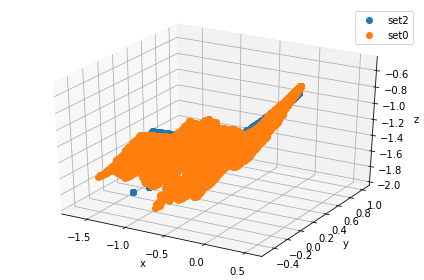

In [155]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot(set10_tr[:,0], set10_tr[:,1], set10_tr[:,2], 'o', label='set0')
# ax.plot(set1[:,0], set1[:,1], set1[:,2], 'o', label='set1')

# ax.plot(set20_tr[:,0], set20_tr[:,1], set20_tr[:,2], 'o', label='set0')
ax.plot(set02_tr[:,0], set02_tr[:,1], set02_tr[:,2], 'o', label='set2')
ax.plot(set0[:,0], set0[:,1], set0[:,2], 'o', label='set0')
# ax.plot(set2[:20,0], set2[:20,1], set2[:20,2], 'o', label='set2')
# ax.plot([set0[i,0],set1[i,0]], [set0[i,1], set1[i,1]], [set0[i,2], set1[i,2]], 'g--')
# ax.plot([set1[i,0],set2[i,0]], [set1[i,1], set2[i,1]], [set1[i,2], set2[i,2]], 'r--')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.tight_layout()
plt.show()

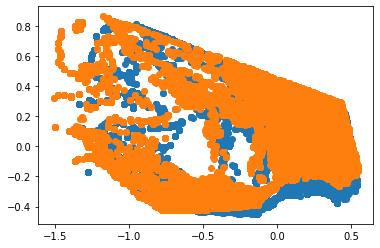

In [156]:
plt.plot(set02_tr[:,0], set02_tr[:,1], 'o', label='set2')
plt.plot(set1[:,0], set1[:,1], 'o', label='set1')

with transformation matrices from t265

In [157]:
t265_435_mcs = [tr @ np.linalg.inv(tm_T265toD435) for tr in t265_tr_mcs]

In [158]:
set0_265 = (np.linalg.inv(tm_T265toD435) @ np.hstack((set0, np.ones((set0.shape[0], 1)))).T).T
set_265_init = (np.linalg.inv(t265_tr_mcs[0]) @ np.linalg.inv(tm_T265toD435) @  np.hstack((set0, np.ones((set0.shape[0], 1)))).T).T
set1_265 = (np.linalg.inv(tm_T265toD435) @ np.hstack((set1, np.ones((set1.shape[0], 1)))).T).T
set2_265 = (np.linalg.inv(tm_T265toD435) @ np.hstack((set2, np.ones((set2.shape[0], 1)))).T).T

In [159]:
set0_265 = (tm_T265toD435 @ np.hstack((set0, np.ones((set0.shape[0], 1)))).T).T
set_265_init = (np.linalg.inv(t265_tr_mcs[0]) @ tm_T265toD435 @  np.hstack((set0, np.ones((set0.shape[0], 1)))).T).T
set1_265 = (tm_T265toD435 @ np.hstack((set1, np.ones((set1.shape[0], 1)))).T).T
set2_265 = (tm_T265toD435 @ np.hstack((set2, np.ones((set2.shape[0], 1)))).T).T

In [160]:
set00_tr = (t265_tr_mcs[0] @ set_265_init.T).T
set10_tr = (t265_tr_mcs[1] @ set_265_init.T).T
set20_tr = (t265_tr_mcs[2] @ set_265_init.T).T
# set21_tr = (regs[1].transformation @ np.hstack((set1, np.ones((set1.shape[0], 1)))).T).T

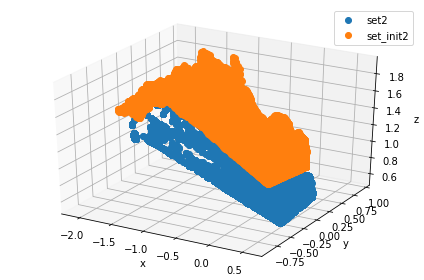

In [161]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot(set10_tr[:,0], set10_tr[:,1], set10_tr[:,2], 'o', label='set0')
# ax.plot(set_265_init[:,0], set_265_init[:,1], set_265_init[:,2], 'o', label='set0_init')
# ax.plot(set0_265[:,0], set0_265[:,1], set0_265[:,2], 'o', label='set0')
# ax.plot(set1_265[:,0], set1_265[:,1], set1_265[:,2], 'o', label='set1')
ax.plot(set2_265[:,0], set2_265[:,1], set2_265[:,2], 'o', label='set2')

# ax.plot(set00_tr[:,0], set00_tr[:,1], set00_tr[:,2], 'o', label='set_init0')
# ax.plot(set10_tr[:,0], set10_tr[:,1], set10_tr[:,2], 'o', label='set_init1')
ax.plot(set20_tr[:,0], set20_tr[:,1], set20_tr[:,2], 'o', label='set_init2')

# ax.plot(set20_tr[:,0], set20_tr[:,1], set20_tr[:,2], 'o', label='set0')
# ax.plot(set02_tr[:,0], set02_tr[:,1], set02_tr[:,2], 'o', label='set2')
# ax.plot(set0[:,0], set0[:,1], set0[:,2], 'o', label='set0')
# ax.plot(set2[:20,0], set2[:20,1], set2[:20,2], 'o', label='set2')
# ax.plot([set0[i,0],set1[i,0]], [set0[i,1], set1[i,1]], [set0[i,2], set1[i,2]], 'g--')
# ax.plot([set1[i,0],set2[i,0]], [set1[i,1], set2[i,1]], [set1[i,2], set2[i,2]], 'r--')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.tight_layout()
plt.show()

In [409]:
d435_frames[0].get_distance(100, 100)

1.371000051498413